<a href="https://colab.research.google.com/github/aeholbrook/conv_eeg/blob/main/Conv_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I put all the dependency installs here, but I intend to go through and make sure we actually *need* all these at a later date. Obviously a git clone will make this easier too.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#%cd ..
!pip install keras-applications -q
!pip install mne -q
!pip install tensorflow-gpu -q

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd /content/drive/MyDrive/Deep_EEG_Project/Shell_Stuff
print("importing requisite libraries...")
from utils import *
%cd /content/
from tqdm import tqdm
from tensorflow.python.client import device_lib
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
mne.utils.set_config('MNE_USE_CUDA', 'true') 
%matplotlib inline
!MNE_USE_CUDA=true python -c "import mne; mne.cuda.init_cuda(verbose=True)"

/content/drive/MyDrive/Deep_EEG_Project/Shell_Stuff
importing requisite libraries...
/content
Num GPUs Available: 1
Now using CUDA device 0
Enabling CUDA with 15.47 GB available memory


#Data Reading and Cleanup

##Read EEGLab files

The first part of our notebook is primarily concerned with reading and cleaning the epoched EEG data processed and provided by the lab with which we are partnering. This data comes from the ***Integrative Neuroscience Laboratory at Southern Illinois University***. 

###File Notation

Files were cleaned and processed as `.set` and `.fdt` format in a *MATLAB* plugin called *EEGLab*. The lab labeled the experimental conditions as follows, using an example file, `0011ec1LE_Bs.set`:


<table>
<tr>
<td>001</td>
<td>1</td>
<td>ec1</td>
<td>LE_Bs</td>
<td>.set</td>
</tr>
<tr>
<td>Subject Number</td>
<td>Experimental Group</td>
<td>Experimental Condition</td>
<td>Cleanup Info</td>
<td>file type</td>
</tr>
</table>

###Epoch Array Organization

We are most concerned here with the file type - we only want to try to read the `.fdt` files - and the experimental group - the 1 or 2 at the 4th position in the `filename` string. This will tell us if the data comes from the *first* condition - participants who had just smoked a cigarette - or the *second* condition - participants who had abstained from smoking for 24 hours before the session. 

Our code will iterate through a `list` of filenames in the `directory` of our choosing and, depending on whether `filename[3]` is a `1` or `2`, place read `mne.Epochs` objects into the array `cond_1` or `cond_2`, which will then be concatenated into one array `conditions` as an output.

##Chunking Epochs

In the interest of artifact reduction, we've decided that our model could be best trained and tested using **chunked** `mne.Epochs` objects. To accomodate this, the `read_files` function takes in a parameter `chunk_size` and merges individual `mne.Epochs` objects from each array into `mne.Epochs` objects, each containing a number of epochs equal to `chunk_size`. These chunks are read by the `process_data()` function later and averaged as though they were a single epoch.

After they are **chunked**, these objects are concatenated into either the `cond_1` or `cond_2` array, which are eventually combined into `conditions` and returned.


In [4]:
def read_files(start=0, stop=10, chunk_size=2):
  cond_1_files = []
  cond_1 = []
  cond_2_files = []
  cond_2 = []

  directory = "/content/drive/MyDrive/Deep_EEG_Project"
  for filename in tqdm(os.listdir(directory)[start:stop], position=0, leave=True):
      if filename.endswith(".set"): 
        if filename[3] == "1":
          cond_1_files.append(filename)
          input = mne.io.read_epochs_eeglab(directory +"/"+ filename, verbose='CRITICAL')
          input_list = [input[i:i + chunk_size] for i in range(0, len(input), chunk_size)]
          cond_1.extend(input_list)
        else:
          cond_2_files.append(filename)
          input = mne.io.read_epochs_eeglab(directory +"/"+ filename, verbose='CRITICAL')
          input_list = [input[i:i + chunk_size] for i in range(0, len(input), chunk_size)]
          cond_2.extend(input_list)
  conditions = [cond_1,cond_2]
  return conditions

In [5]:
def process_data(conditions,condition_labels,f_low=4,f_high=30,f_bins=26, decim=10):
  labels_arr = np.concatenate([np.full(len(item),idx) for idx,item in enumerate(conditions)])
  #A lambda function which performs a morlet power spectral density transformation on an inputted MNE Epochs object and outputs an array containing the spectral data
  process_epochs = lambda epoch : np.asarray(mne.time_frequency.tfr_morlet(epoch, freqs = np.linspace(f_low, f_high, f_bins, endpoint=True), n_cycles=3, decim=decim, n_jobs=100, verbose = False)[0].data)
  conditions = np.concatenate([list(map(process_epochs, cond)) for cond in tqdm(conditions)])
  return conditions, labels_arr, f_bins

In [2]:
condition_labels = ["Smoking","Abstinence"]

Now, we can read the input files into the session, and these two lines of code will aggregate them into a numpy array of the following shape:

> `input_arr.shape` = $n_{epochs}$, $n_{electrodes}$, $n_{frequencies}$, $n_{measurements}$

> `input_labels.shape` = $n_{epochs}$

$n_{epochs}$ is the number of epochs in our sample divided by `chunk_size`,

$n_{electrodes}$ is the number of electrodes provided in our data - here $29$.

$n_{frequencies}$ = `f_bins`, or the number of discrete frequencies output by the morlet transformation.

$n_{measurements}$ are the number of point samples performed per epoch, divided by `decim`.



In [6]:
def read_and_save(start=0, stop=101):
  print("\nReading Files ", start, " - ", stop, "from directory...")
  conditions = read_files(start,stop)
  print("\nPerforming Morlet transformation on Epoch data")
  input_arr, input_labels, f_bins = process_data(conditions, condition_labels) 
  filename = "morlet_transform_"+str(start)+"_"+str(stop)
  np.save(filename+".npy",input_arr_test)
  np.save(filename+"_labels.npy",input_labels_test)
  return input_arr,input_labels

In [3]:
start = 0
stop = 100
filename = "morlet_transform_"+str(start)+"_"+str(stop)
input_arr = np.load(filename+".npy")
input_labels = np.load(filename+"_labels.npy")
start = 101
stop = 200
filename = "morlet_transform_"+str(start)+"_"+str(stop)
input_arr = np.concatenate((input_arr,np.load(filename+".npy")))
input_labels = np.concatenate((input_labels,np.load(filename+"_labels.npy")))
start = 201
stop = 300
filename = "morlet_transform_"+str(start)+"_"+str(stop)
input_arr = np.concatenate((input_arr,np.load(filename+".npy")))
input_labels = np.concatenate((input_labels,np.load(filename+"_labels.npy")))
start = 301
stop = 400
filename = "morlet_transform_"+str(start)+"_"+str(stop)
input_arr = np.concatenate((input_arr,np.load(filename+".npy")))
input_labels = np.concatenate((input_labels,np.load(filename+"_labels.npy")))

In [4]:
print("\nShape of input array:")
print(input_arr.shape)
print("\nInput Labels Size:")
print(input_labels.shape)


Shape of input array:
(5822, 29, 26, 205)

Input Labels Size:
(5822,)



##EEG Data Visualization

EEG data can sometimes be difficult to display, as it is 2-Dimensional data expressed over a period of time. However, since we performed the **Morlet Transform** on our EEG data, we now have an array expressing the **Power Spectral Density** at each site on our EEG cap.

Because we averaged the data for several electrodes using `chunk_size`, the dataset we are currently working with is the averaged electrical activity measured at each of $29$ electrodes over a period of $4\ *$ `chunk_size` seconds of measurement. This measurement is then **decimated**, such that the $2048$ point samples measured per $4$-second epoch are divided by the number represented by `decim`. Below are topographic and plotted representations of that data, for both the **smoking** and **nonsmoking** condition:

    Using multitaper spectrum estimation with 7 DPSS windows


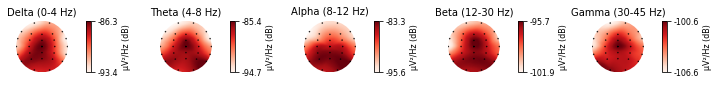

    Using multitaper spectrum estimation with 7 DPSS windows


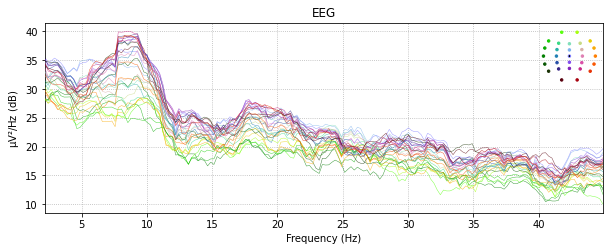

    Using multitaper spectrum estimation with 7 DPSS windows


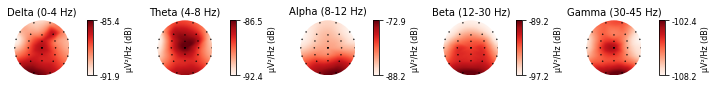

    Using multitaper spectrum estimation with 7 DPSS windows


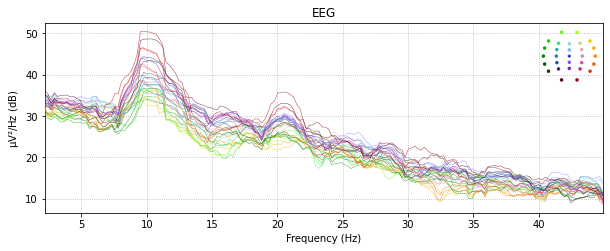

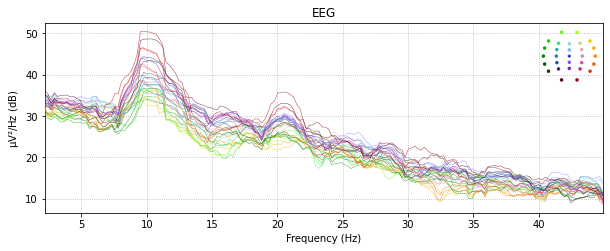

In [9]:
conditions[0][5].plot_psd_topomap()
conditions[0][5].plot_psd(2,45)
conditions[1][5].plot_psd_topomap()
conditions[1][5].plot_psd(2,45)

##Input Value Shuffling

This function will shuffle the input values in `input_arr`, which are currently sorted by condition, into a random assortment if conditions. 

In [6]:
def shuffle_and_split(input_arr, input_labels, split_val = 1, multiply_constant = 1000000000, axes_to_merge = (0,1), random_forest=False):
  input_arr = np.concatenate(np.split(input_arr,split_val,axis=-1))
  input_arr *= multiply_constant
  input_labels_split = np.repeat(input_labels,split_val)
  indices = tf.range(start=0, limit=input_arr.shape[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  input_arr = np.take(input_arr, shuffled_indices, axis=0)
  shuffled_input_labels = np.take(input_labels_split, shuffled_indices, axis=0)

  if random_forest:
    input_arr = np.mean(input_arr, axis = -1)
    input_arr = input_arr.reshape(input_arr.shape[0], -1)
  else:
    input_arr = np.mean(input_arr, axis = -1)
    arr_shape = [input_arr.shape[item] for item in axes_to_merge]
    arr_shape = np.append(arr_shape,-1)
    input_arr = np.reshape(input_arr,arr_shape)
    print(input_arr.shape)

  return input_arr, shuffled_input_labels, split_val

##Random Forest

Here, we are building and training a ***Random Forest Classifier***, the performance of which will be compared to that of the ***Convolutional Neural Network*** we will eventually train to make predictions on this data.

[Here is a fun video outlining the construction and interpretation of a ***Random Forest*** machine learning model.](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&vl=pt)

###Inputs to Model

This random forest will use the `shuffle_and_split()` function to shuffle the `input_arr` and `input_labels` arrays in order to better randomize the data which will be presented to the model. 

Then, we will use the `train_test_split()` function to separate the shuffled data and labels into `train` and `test` sections, with the `test_size` parameter indicating the ratio of `test` data to `train` data. 

It's important to split the data into test and train sets, in order to avoid overfitting your model on the data it's seeing.

###Outputs to Model

We are using the `sklearn` `metrics` library to estimate the accuracy of the ***Random Forest*** model on data it has not yet seen. The command `metrics.accuracy_score(y_test, y_pred_2)` compares the model's predictions for the test set, and the actual values for this set.

Additionally, we can use our classifier's `feature_importances_` attribute to read out a list of how much value the classifier places on each feature in our dataset, although in the data given that may not be extremely informative as to what is driving differences between conditions in our data.

In [3]:
import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
shuffled_input_array, shuffled_input_labels, split_val = shuffle_and_split(input_arr, input_labels, axes_to_merge=(0,1,2,-1), random_forest=True)
x_train,x_test,y_train,y_test = train_test_split(shuffled_input_array,shuffled_input_labels,test_size=0.1)
clf2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=100,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf2.fit(x_train,y_train)

y_pred_2=clf2.predict(x_test)

import pandas as pd
from sklearn import metrics
feature_imp_2 = pd.Series(clf2.feature_importances_).sort_values(ascending=False)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_2))
print("Mean Feature Importance:",np.mean(feature_imp_2))

NameError: ignored

In [11]:
del clf2

##Test and Train Split

Similar to above, we will be shuffling our data using the `shuffle_and_split()` function, then using the `train_test_split()` function to separate the shuffled data and labels into `train` and `test` sections, with the `test_size` parameter indicating the ratio of test data to train data. 

We need to use the `tf.expand.dims` command to add an extra axis to the test and train inputs. `tensorflow` will use this extra dimension to store the ***features*** its **convolution layers** will be trained to detect. 



In [7]:
shuffled_input_arr, input_labels, split_val = shuffle_and_split(input_arr, input_labels, axes_to_merge=(0,1), random_forest=False)
x_train,x_test,y_train,y_test = train_test_split(shuffled_input_arr,input_labels,test_size=0.2)
x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)
print("X Train:", x_train.shape)
print("Y Train:", y_train.shape)

(5822, 29, 26)
X Train: (4657, 29, 26, 1)
Y Train: (4657,)


In [9]:
def build_model():
  model = keras.models.Sequential()
  input_shape = x_train.shape[1:]
  model.add(keras.Input(shape=input_shape))

  model.add(keras.layers.Conv2D(26,(3,3),activation='relu', input_shape = input_shape))
  model.add(keras.layers.Conv2D(26,(3,3),activation='relu'))
  #model.add(keras.layers.Conv2D(26,(3,3),activation='relu'))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

  model.add(keras.layers.Dropout(.2))
  model.add(keras.layers.Dense(3000, activation='relu'))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1,activation='sigmoid'))
  model.build()
  model.summary()
  return model

In [10]:
model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 24, 26)        260       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 22, 26)        6110      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 11, 26)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 11, 26)        0         
_________________________________________________________________
dense (Dense)                (None, 12, 11, 3000)      81000     
_________________________________________________________________
flatten (Flatten)            (None, 396000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [15]:
batch_size = 1
epochs = 5

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Create a callback that saves the model's weights
mdl_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[mdl_callback])


Epoch 1/5
3725/3725 [==============================] - 11s 3ms/step - loss: 0.2295 - accuracy: 0.9075 - val_loss: 0.2769 - val_accuracy: 0.8873
Epoch 2/5
3725/3725 [==============================] - 10s 3ms/step - loss: 0.2202 - accuracy: 0.9098 - val_loss: 0.2210 - val_accuracy: 0.9195
Epoch 3/5
3725/3725 [==============================] - 10s 3ms/step - loss: 0.1895 - accuracy: 0.9301 - val_loss: 0.2156 - val_accuracy: 0.9131
Epoch 4/5
3725/3725 [==============================] - 10s 3ms/step - loss: 0.1997 - accuracy: 0.9164 - val_loss: 0.2271 - val_accuracy: 0.9142
Epoch 5/5
3725/3725 [==============================] - 10s 3ms/step - loss: 0.1865 - accuracy: 0.9229 - val_loss: 0.2830 - val_accuracy: 0.8916


In [22]:
#print(model.test_on_batch(x_train_2[:300], y_train_2[:300]))

model.save("curr_model")


INFO:tensorflow:Assets written to: curr_model/assets


Here is where I am going to add some test data from the other side of the fileset so the net is getting data it's never seen before.

In [17]:
start = 401
stop = 500
filename = "morlet_transform_"+str(start)+"_"+str(stop)
input_arr_2 = np.load(filename+".npy")
input_labels_2 = np.load(filename+"_labels.npy")
shuffled_input_arr_2, input_labels_2, split_val = shuffle_and_split(input_arr_2, input_labels_2, axes_to_merge=(0,1), random_forest=False)
x_train_2,x_test_2,y_train_2,y_test_2 = train_test_split(shuffled_input_arr_2,input_labels_2,test_size=0.2)
x_train_2 = tf.expand_dims(x_train_2, axis=-1)
x_test_2 = tf.expand_dims(x_test_2, axis=-1)
print("X Train:", x_train_2.shape)
print("Y Train:", y_train_2.shape)

(5822, 29, 26)
X Train: (4657, 29, 26, 1)
Y Train: (4657,)


In [ ]:
start = 0
stop = 100
print("Reading Files ", start, " - ", stop, "from directory...")
conditions = read_files(start,stop)
print("Performing Morlet transformation on Epoch data")
input_arr, input_labels, f_bins = process_data(conditions, condition_labels)
np.save("morlet_transform", start, "-", stop, ".npy",input_arr)
np.save("morlet_transform", start, "-", stop, "_labels.npy",input_arr,input_labels)